# Adversarial Attack on MNIST

Here, we use the tutorial "Deep MNIST for experts" inspired by this link- https://github.com/DobrinGanev/Deep-MNIST-for-Experts-Tensorflow-Example/blob/master/multilayer-convolutional-network.ipynb

The functions are modified to use tf.keras API.

# Import packages

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

# Load MNIST dataset

In [2]:
#Read the input data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

# Check a sample image

Training image shape (55000, 784)
Training labels shape (55000, 10)
Shape of an image (1, 784)


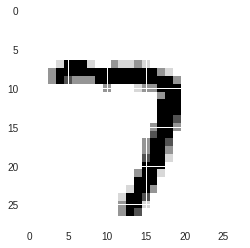

In [3]:
#Explore the data
sample_image = mnist.train.next_batch(1)[0]
print("Training image shape", mnist.train.images.shape)
print("Training labels shape", mnist.train.labels.shape)
print("Shape of an image", sample_image.shape)
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image)

# Create placeholder for Image and Labels

In [0]:
x = tf.keras.backend.placeholder(shape=[None, 784], dtype=tf.float32)
y_ = tf.keras.backend.placeholder(shape=[None, 10], dtype=tf.float32)

# Create function for Convolution and MaxPooling based on the tutorial for "Deep MNIST for experts". Here conv2d and maxpooling use tf.keras API.

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.keras.backend.conv2d(x, W, strides=(1, 1), padding='same')

def max_pooling_2x2(x):
    return tf.keras.backend.pool2d(x, pool_size=(2,2), strides=(2,2), padding='same')

# Create Convolutional Neural Network

In [0]:
x_image = tf.reshape(x, [-1,28,28,1])

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

# Probabilities, Loss, Optimizer and Test Accuracy initialization

In [0]:
# Get Probabilities
y = tf.nn.softmax(y_conv)

In [0]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [0]:
# Test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize global variables for training

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Start training

In [11]:
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

  0%|          | 1/1000 [00:02<40:46,  2.45s/it]

step 0, training accuracy 0.15


 21%|██        | 210/1000 [00:05<00:10, 73.51it/s]

step 200, training accuracy 0.91


 41%|████      | 410/1000 [00:07<00:07, 74.09it/s]

step 400, training accuracy 0.95


 61%|██████    | 610/1000 [00:10<00:05, 71.72it/s]

step 600, training accuracy 0.96


 81%|████████  | 810/1000 [00:13<00:02, 74.96it/s]

step 800, training accuracy 0.98


100%|██████████| 1000/1000 [00:15<00:00, 62.64it/s]


# Print Accuracy on test data

In [12]:
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))

test accuracy 0.966


# Filter Index for 2s images and the images

In [0]:
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

# Print probabilities and predictions for chosen images

In [14]:
prediction = tf.argmax(y,1)
prediction_val = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
print("predictions", prediction_val)
probabilities = y
probabilities_val = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
print ("probabilities", probabilities_val)

predictions [2 2 2 2 2 2 2 2 2 2]
probabilities [[1.48450359e-04 9.87485168e-04 9.97328520e-01 6.28331152e-04
  7.51353241e-07 1.80426468e-05 8.68445088e-04 3.75354858e-07
  1.96363890e-05 1.20898136e-08]
 [3.79555968e-06 4.59429029e-05 9.99640822e-01 1.92118430e-04
  3.81106730e-07 3.04707792e-05 1.45119179e-06 2.08055590e-05
  6.39804857e-05 2.45621408e-07]
 [8.42797849e-03 9.77772195e-03 8.44806492e-01 1.33591264e-01
  5.42416228e-06 1.30756479e-03 9.85995983e-04 4.96295106e-05
  1.03941653e-03 8.40825669e-06]
 [3.12331795e-05 1.19215669e-03 9.97555435e-01 5.10628917e-04
  1.79100418e-04 2.87168109e-06 4.21465636e-04 9.52872942e-05
  1.07909018e-05 9.25337815e-07]
 [1.80918378e-05 6.18721606e-05 9.97954488e-01 1.03500625e-03
  1.85136421e-04 1.72186610e-05 6.32094045e-04 1.27352560e-05
  8.07614051e-05 2.60343722e-06]
 [3.83387887e-05 4.42070859e-06 9.99201000e-01 7.45633442e-04
  7.33085201e-08 1.90450282e-06 2.05652569e-07 5.35173194e-06
  2.75863704e-06 3.39459746e-07]
 [5.930085

# Plot images with probabilities

Correct label 0
Predicted label: 2
Confidence: 0.9973285


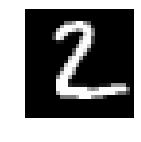

Correct label 0
Predicted label: 2
Confidence: 0.9996408


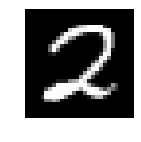

Correct label 0
Predicted label: 2
Confidence: 0.8448065


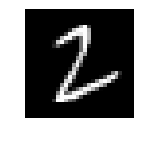

Correct label 0
Predicted label: 2
Confidence: 0.99755543


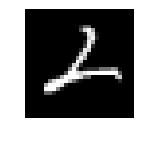

Correct label 0
Predicted label: 2
Confidence: 0.9979545


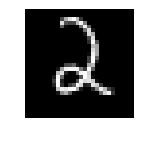

Correct label 0
Predicted label: 2
Confidence: 0.999201


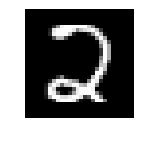

Correct label 0
Predicted label: 2
Confidence: 0.9636465


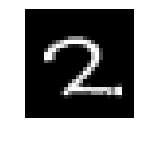

Correct label 0
Predicted label: 2
Confidence: 0.99999917


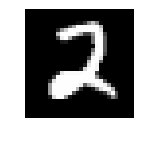

Correct label 0
Predicted label: 2
Confidence: 0.999461


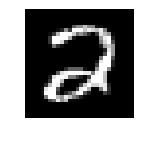

Correct label 0
Predicted label: 2
Confidence: 0.8694943


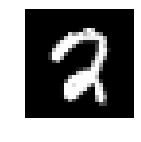

In [15]:
for i in range(0, 10):
    print('Correct label', np.argmax(index_of_2s[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(x_batch[i].reshape([28, 28]),cmap = "gray")
    plt.show()

# Initialize target label and the matrix for the adversarial attack

In [0]:
target_number = 6
target_labels = np.zeros((10, 10))
target_labels[:, target_number] = 1

In [17]:
target_labels

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

# Initialize gradient for Adversarial attack

In [0]:
img_gradient = tf.gradients(cross_entropy, x)[0]

# Initialize value for step size and number of steps

In [0]:
step_size = 0.01
steps = 10

# Calculate Image Gradient and run FGSM attack

In [20]:
adversarial_img = x_batch.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    adversarial_img = adversarial_img + step_size * np.sign(gradient)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])
prob2_hist.append(probabilities_val[:,2])
prob6_hist.append(probabilities_val[:,6])

predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [0.9985557  0.9998172  0.8963791  0.9986613  0.99897563 0.99954385
 0.97982055 0.99999964 0.99971837 0.9275274 ]
Confidence 6: [2.4300229e-04 3.0895796e-07 2.5161207e-04 1.3950853e-04 2.0347600e-04
 4.7626116e-08 2.1088012e-05 2.4103661e-09 1.6256938e-06 1.6687731e-03]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [0.9993519  0.9999163  0.93783146 0.99940073 0.99952424 0.99972075
 0.9876716  0.9999999  0.9998554  0.96314937]
Confidence 6: [5.0066636e-05 5.9283110e-08 5.6101977e-05 3.2264754e-05 4.7901878e-05
 9.8577120e-09 5.1022316e-06 5.3665328e-10 3.1884201e-07 4.0689280e-04]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [0.99966955 0.999962   0.9639171  0.99971646 0.9997838  0.9998369
 0.99332386 0.9999999  0.99992764 0.9787933 ]
Confidence 6: [1.1195409e-05 1.1802582e-08 1.3122697e-05 7.8643898e-06 1.1596924e-05
 2.1887969e-09 1.3538115e-06 1.3875505e-10 6.5334916e-08 1.0771635e-04]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2:

# Plot Image grid of original image, adversarial image and noise

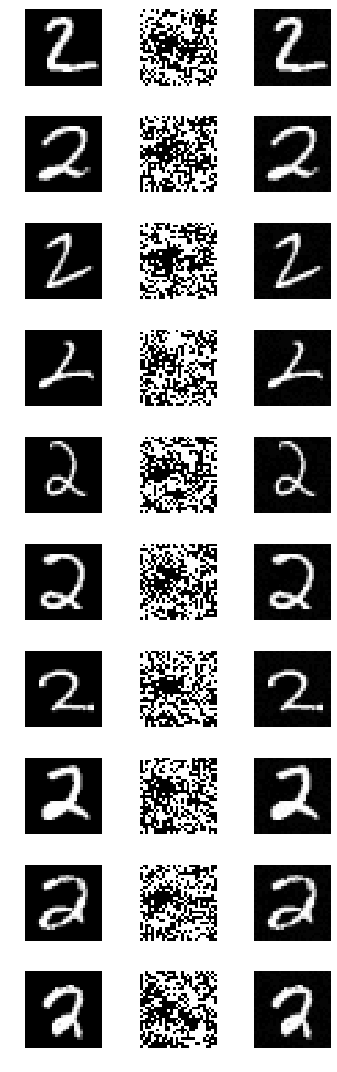

In [21]:
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(x_batch[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - x_batch[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()